# Elo Score Calculation

In [1]:
import re
import os
from collections import defaultdict

In [2]:
from datetime import datetime
from datetime import timedelta
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd
import xlrd

In [4]:
# Increase size of plot in jupyter

plt.rcParams["figure.figsize"] = (18,10)

## Summary

- Notebook that calcuates the Elo Score of mice competing over access to a tone associated reward port
- The data is a spreadsheet of combination of subjects (as rows) against dates (as columns)

## Importing Data

- The original data has been trimmed so that only the cells with dates, winner ID's, and relevant metadata were kept

In [5]:
xls = pd.ExcelFile("./data/Home_Cage_Behaviors_Data.xlsx")
sheets = xls.sheet_names

In [6]:
sheets

['Elo_Score_Data', 'CAGE1', 'CAGE2', 'CAGE3', 'CAGE4', 'CAGE5', 'CAGE6']

In [142]:
home_cage_observations_df = pd.read_excel("./data/Home_Cage_Behaviors_Data.xlsx", sheet_name=sheets[1], header=1)

In [143]:
copy_home_cage_observations_df = home_cage_observations_df.copy()

In [144]:
home_cage_observations_df.head()

,observer,notes,length of observations,date,cage #,initiator,receiver,action,1,2,3,4
0,Isabel,"9:27-9:57am, C57 lots of grooming and rearing",30min,2022-06-29,1.0,3,1,fs,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaT,1.0,1,2,fs,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaT,1.0,1,4,ag,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaT,1.0,1,4,as,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaT,1.0,1,2,ag,NaN,NaN,NaN,NaN


## Adding the session number

- Each new session has the date as a row, so we will get the index of all the rows with dates

In [145]:
home_cage_observations_df.dropna(axis=0, subset="date")

,observer,notes,length of observations,date,cage #,initiator,receiver,action,1,2,3,4
0,Isabel,"9:27-9:57am, C57 lots of grooming and rearing",30min,2022-06-29,1.0,3,1,fs,NaN,NaN,NaN,NaN
20,Meghan,"1:06-1:36PM, lots of grooming due to bleaching...",30min,2022-06-29,1.0,1,3,fs,NaN,NaN,NaN,NaN
46,Erika,"10:55 am - 11:25 am, C57",30 min,2022-06-29,1.0,2,4,as,NaN,NaN,NaN,NaN
62,Catalina,"C57, 2:30 pm - 3:00 pm",30 minutes,2022-06-30,1.0,2,4,fs,NaN,NaN,NaN,NaN
75,Naeliz,"C57, 10:58am-11:29am",30 min,2022-07-01,1.0,4,3,fs,NaN,NaN,NaN,NaN
96,Nancy,1157-1227pm observation after 30 min isolation...,30 min,2022-07-02,1.0,1,3,fs,NaN,NaN,NaN,NaN
107,Isabel,9:26am C57 observation without mouse 1,30min,2022-07-03,1.0,4,2,ag,NaN,NaN,NaN,NaN
113,Isabel,"more energetic when the alpha came back, but s...",15min,2022-07-03,1.0,3,2,fs,NaN,NaN,NaN,NaN
123,erika,"C57, removal of mouse 2, 10 min habituation (1...",30 min,2022-07-04,1.0,1,4,fs,NaN,NaN,NaN,NaN
144,erika,"C57, reintroduction of mouse 2 into cage, obse...",15 min,2022-07-04,1.0,2,3,fs,NaN,NaN,NaN,NaN


In [146]:
home_cage_observations_df.dropna(axis=0, subset="date").index

Int64Index([0, 20, 46, 62, 75, 96, 107, 113, 123, 144, 155, 166, 172, 187,
            194],
           dtype='int64')

In [147]:
home_cage_observations_df["session_number"] = np.nan

In [148]:
session_number = 1
for index in home_cage_observations_df.dropna(axis=0, subset="date").index:
    home_cage_observations_df.at[index, "session_number"] = session_number
    session_number += 1

In [149]:
home_cage_observations_df

,observer,notes,length of observations,date,cage #,initiator,receiver,action,1,2,3,4,session_number
0,Isabel,"9:27-9:57am, C57 lots of grooming and rearing",30min,2022-06-29,1.0,3,1,fs,NaN,NaN,NaN,NaN,1.0
1,NaN,NaN,NaN,NaT,1.0,1,2,fs,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaT,1.0,1,4,ag,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaT,1.0,1,4,as,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaT,1.0,1,2,ag,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
196,NaN,NaN,NaN,NaT,NaN,2,1,f,-1.0,1.0,NaN,NaN,NaN
197,NaN,NaN,NaN,NaT,NaN,2,1,f,-1.0,1.0,NaN,NaN,NaN
198,NaN,NaN,NaN,NaT,NaN,2,1,c,-1.0,1.0,NaN,NaN,NaN
199,NaN,NaN,NaN,NaT,NaN,2,1,f,-1.0,1.0,NaN,NaN,NaN


- Filling in the empty cells with the previous row's values

In [150]:
home_cage_observations_df = home_cage_observations_df.fillna(method='ffill')

In [151]:
home_cage_observations_df.fillna(method='ffill')

,observer,notes,length of observations,date,cage #,initiator,receiver,action,1,2,3,4,session_number
0,Isabel,"9:27-9:57am, C57 lots of grooming and rearing",30min,2022-06-29,1.0,3,1,fs,NaN,NaN,NaN,NaN,1.0
1,Isabel,"9:27-9:57am, C57 lots of grooming and rearing",30min,2022-06-29,1.0,1,2,fs,NaN,NaN,NaN,NaN,1.0
2,Isabel,"9:27-9:57am, C57 lots of grooming and rearing",30min,2022-06-29,1.0,1,4,ag,NaN,NaN,NaN,NaN,1.0
3,Isabel,"9:27-9:57am, C57 lots of grooming and rearing",30min,2022-06-29,1.0,1,4,as,NaN,NaN,NaN,NaN,1.0
4,Isabel,"9:27-9:57am, C57 lots of grooming and rearing",30min,2022-06-29,1.0,1,2,ag,NaN,NaN,NaN,NaN,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
196,Jocelyn,We noticed mice were fighting during the tube ...,15min,2022-07-07,1.0,2,1,f,-1.0,1.0,-1.0,1.0,15.0
197,Jocelyn,We noticed mice were fighting during the tube ...,15min,2022-07-07,1.0,2,1,f,-1.0,1.0,-1.0,1.0,15.0
198,Jocelyn,We noticed mice were fighting during the tube ...,15min,2022-07-07,1.0,2,1,c,-1.0,1.0,-1.0,1.0,15.0
199,Jocelyn,We noticed mice were fighting during the tube ...,15min,2022-07-07,1.0,2,1,f,-1.0,1.0,-1.0,1.0,15.0


- Making another column for vertical lines for plotting

In [152]:
home_cage_observations_df["session_number_plotting"] = np.nan

In [153]:
session_number = 1
for index in copy_home_cage_observations_df.dropna(axis=0, subset="date").index:
    home_cage_observations_df.at[index, "session_number_plotting"] = session_number
    session_number += 1

In [154]:
home_cage_observations_df.dropna(subset="session_number_plotting")

,observer,notes,length of observations,date,cage #,initiator,receiver,action,1,2,3,4,session_number,session_number_plotting
0,Isabel,"9:27-9:57am, C57 lots of grooming and rearing",30min,2022-06-29,1.0,3,1,fs,NaN,NaN,NaN,NaN,1.0,1.0
20,Meghan,"1:06-1:36PM, lots of grooming due to bleaching...",30min,2022-06-29,1.0,1,3,fs,NaN,NaN,NaN,NaN,2.0,2.0
46,Erika,"10:55 am - 11:25 am, C57",30 min,2022-06-29,1.0,2,4,as,NaN,NaN,NaN,NaN,3.0,3.0
62,Catalina,"C57, 2:30 pm - 3:00 pm",30 minutes,2022-06-30,1.0,2,4,fs,NaN,NaN,NaN,NaN,4.0,4.0
75,Naeliz,"C57, 10:58am-11:29am",30 min,2022-07-01,1.0,4,3,fs,NaN,NaN,NaN,NaN,5.0,5.0
96,Nancy,1157-1227pm observation after 30 min isolation...,30 min,2022-07-02,1.0,1,3,fs,NaN,NaN,NaN,NaN,6.0,6.0
107,Isabel,9:26am C57 observation without mouse 1,30min,2022-07-03,1.0,4,2,ag,NaN,NaN,NaN,NaN,7.0,7.0
113,Isabel,"more energetic when the alpha came back, but s...",15min,2022-07-03,1.0,3,2,fs,NaN,NaN,NaN,NaN,8.0,8.0
123,erika,"C57, removal of mouse 2, 10 min habituation (1...",30 min,2022-07-04,1.0,1,4,fs,NaN,NaN,NaN,NaN,9.0,9.0
144,erika,"C57, reintroduction of mouse 2 into cage, obse...",15 min,2022-07-04,1.0,2,3,fs,-1.0,NaN,-1.0,1.0,10.0,10.0


## Getting a list of all the animals

- Because each cell does not contain the ID of all the animals that were competing, we will make a new column with both ID's

In [155]:
def get_all_animal_ids(animal_string):
    """
    Converts a string that contains the ID of animals, and only gets the IDs. 
    This usually removes extra characters that were added. (i.e. "1.1 v 2.2" to ("1.1", "2.2"))

    Args:
        animal_string(str): This is the first param.

    Returns:
        tuple: Of IDs of animals as strings
    """
    # Splitting by space so that we have a list of just the words
    all_words = animal_string.split()
    # Removing all words that are not numbers
    all_numbers = [num for num in all_words if re.match(r'^-?\d+(?:\.\d+)$', num)]
    return tuple(all_numbers)


In [156]:
def calculate_elo_score(subject_elo_score, agent_elo_score, k_factor=20, score=1, number_of_decimals=None):
    """
    Calculates the Elo score of a given subject given it's original score, it's opponent, 
    the K-Factor, and whether or not it has won or not. 
    The calculation is based on: https://www.omnicalculator.com/sports/elo

    Args:
        subject_elo_score(float): The original Elo score for the subject
        agent_elo_score(float): The original Elo score for the agent
        k_factor(int): k-factor, or development coefficient. 
            - It usually takes values between 10 and 40, depending on player's strength 
        score(int): the actual outcome of the game. 
            - In chess, a win counts as 1 point, a draw is equal to 0.5, and a lose gives 0.
        number_of_decimals(int): Number of decimals to round to
        
    Returns:
        int: Updated Elo score of the subject
    """
    # Calculating the Elo score
    rating_difference = agent_elo_score - subject_elo_score
    expected_score = 1 / (1 + 10 ** (rating_difference / 400))
    new_elo_score = subject_elo_score + k_factor * (score - expected_score)
    # Rounding to `number_of_decimals`
    return round(new_elo_score, number_of_decimals)

## Get the Elo score for one fight

In [157]:
# Dictionary that keeps track of the current Elo score of the subject
id_to_elo_score = defaultdict(lambda:1000)

index_to_elo_score_and_meta_data = defaultdict(dict)
# Iterating through each column which is a day
all_indexes = iter(range(0, 99999))

# Keeping track of the number of matches
id_to_match_number = defaultdict(lambda:1)
total_match_number = 1
for index, row in home_cage_observations_df.iterrows():
    # Checking if there is an Nan or not
    if row["initiator"] == "nan":
        continue
    else:            
        winner_id = row["initiator"]
    date = row["date"]
    # Getting the ID of the loser subject
    loser_id = row["receiver"]
    # Getting the current Elo Score
    current_winner_rating = id_to_elo_score[winner_id] 
    current_loser_rating = id_to_elo_score[loser_id] 
    # Calculating Elo score            
    id_to_elo_score[winner_id] = calculate_elo_score(subject_elo_score=current_winner_rating, agent_elo_score=current_loser_rating, score=1, number_of_decimals=1)
    id_to_elo_score[loser_id] = calculate_elo_score(subject_elo_score=current_loser_rating, agent_elo_score=current_winner_rating, score=0, number_of_decimals=1)

    # Saving all the data for the winner
    winner_index = next(all_indexes)
    index_to_elo_score_and_meta_data[winner_index]["date"] = date
    index_to_elo_score_and_meta_data[winner_index]["match_number"] = id_to_match_number[str(date)]
    index_to_elo_score_and_meta_data[winner_index]["cage"] = row["cage #"]
    index_to_elo_score_and_meta_data[winner_index]["subject_id"] = winner_id
    index_to_elo_score_and_meta_data[winner_index]["agent_id"] = loser_id
    index_to_elo_score_and_meta_data[winner_index]["original_elo_score"] = current_winner_rating
    index_to_elo_score_and_meta_data[winner_index]["updated_elo_score"] = id_to_elo_score[winner_id]
    index_to_elo_score_and_meta_data[winner_index]["win_draw_loss"] = 1
    index_to_elo_score_and_meta_data[winner_index]["session_number"] = row["session_number"]
    index_to_elo_score_and_meta_data[winner_index]["session_number_plotting"] = row["session_number_plotting"]

    index_to_elo_score_and_meta_data[winner_index]["total_match_number"] = total_match_number



    # Saving all the data for the loser
    loser_index = next(all_indexes)
    index_to_elo_score_and_meta_data[loser_index]["date"] = date
    index_to_elo_score_and_meta_data[loser_index]["match_number"] = id_to_match_number[str(date)]
    index_to_elo_score_and_meta_data[loser_index]["cage"] = row["cage #"]
    index_to_elo_score_and_meta_data[loser_index]["subject_id"] = loser_id
    index_to_elo_score_and_meta_data[loser_index]["agent_id"] = winner_id
    index_to_elo_score_and_meta_data[loser_index]["original_elo_score"] = current_loser_rating
    index_to_elo_score_and_meta_data[loser_index]["updated_elo_score"] = id_to_elo_score[loser_id]
    index_to_elo_score_and_meta_data[loser_index]["win_draw_loss"] = 0
    index_to_elo_score_and_meta_data[loser_index]["session_number"] = row["session_number"]
    index_to_elo_score_and_meta_data[loser_index]["session_number_plotting"] = row["session_number_plotting"]

    index_to_elo_score_and_meta_data[loser_index]["total_match_number"] = total_match_number


    total_match_number += 1
    id_to_match_number[str(date)] += 1
    

In [158]:
id_to_elo_score

defaultdict(<function __main__.<lambda>()>,
            {3: 975.7, 1: 939.0, 2: 1087.9, 4: 997.4})

In [159]:
index_to_elo_score_and_meta_data[0]

{'date': Timestamp('2022-06-29 00:00:00'),
 'match_number': 1,
 'cage': 1.0,
 'subject_id': 3,
 'agent_id': 1,
 'original_elo_score': 1000,
 'updated_elo_score': 1010.0,
 'win_draw_loss': 1,
 'session_number': 1.0,
 'session_number_plotting': 1.0,
 'total_match_number': 1}

In [160]:
home_cage_elo_score_df = pd.DataFrame.from_dict(index_to_elo_score_and_meta_data, orient="index")

In [161]:
home_cage_elo_score_df

,date,match_number,cage,subject_id,agent_id,original_elo_score,updated_elo_score,win_draw_loss,session_number,session_number_plotting,total_match_number
0,2022-06-29,1,1.0,3,1,1000.0,1010.0,1,1.0,1.0,1
1,2022-06-29,1,1.0,1,3,1000.0,990.0,0,1.0,1.0,1
2,2022-06-29,2,1.0,1,2,990.0,1000.3,1,1.0,NaN,2
3,2022-06-29,2,1.0,2,1,1000.0,989.7,0,1.0,NaN,2
4,2022-06-29,3,1.0,1,4,1000.3,1010.3,1,1.0,NaN,3
...,...,...,...,...,...,...,...,...,...,...,...
397,2022-07-07,5,1.0,1,2,958.9,951.9,0,15.0,NaN,199
398,2022-07-07,6,1.0,2,1,1075.0,1081.6,1,15.0,NaN,200
399,2022-07-07,6,1.0,1,2,951.9,945.3,0,15.0,NaN,200
400,2022-07-07,7,1.0,2,1,1081.6,1087.9,1,15.0,NaN,201


In [162]:
home_cage_elo_score_df[home_cage_elo_score_df["date"] == "2022-05-04"]

,date,match_number,cage,subject_id,agent_id,original_elo_score,updated_elo_score,win_draw_loss,session_number,session_number_plotting,total_match_number


In [163]:
home_cage_elo_score_df["date"]

0     2022-06-29
1     2022-06-29
2     2022-06-29
3     2022-06-29
4     2022-06-29
         ...    
397   2022-07-07
398   2022-07-07
399   2022-07-07
400   2022-07-07
401   2022-07-07
Name: date, Length: 402, dtype: datetime64[ns]

In [164]:
home_cage_elo_score_df[home_cage_elo_score_df["date"] == "2022-05-02" ]

,date,match_number,cage,subject_id,agent_id,original_elo_score,updated_elo_score,win_draw_loss,session_number,session_number_plotting,total_match_number


In [165]:
home_cage_elo_score_df.head(n=30)

,date,match_number,cage,subject_id,agent_id,original_elo_score,updated_elo_score,win_draw_loss,session_number,session_number_plotting,total_match_number
0,2022-06-29,1,1.0,3,1,1000.0,1010.0,1,1.0,1.0,1
1,2022-06-29,1,1.0,1,3,1000.0,990.0,0,1.0,1.0,1
2,2022-06-29,2,1.0,1,2,990.0,1000.3,1,1.0,NaN,2
3,2022-06-29,2,1.0,2,1,1000.0,989.7,0,1.0,NaN,2
4,2022-06-29,3,1.0,1,4,1000.3,1010.3,1,1.0,NaN,3
5,2022-06-29,3,1.0,4,1,1000.0,990.0,0,1.0,NaN,3
6,2022-06-29,4,1.0,1,4,1010.3,1019.7,1,1.0,NaN,4
7,2022-06-29,4,1.0,4,1,990.0,980.6,0,1.0,NaN,4
8,2022-06-29,5,1.0,1,2,1019.7,1028.8,1,1.0,NaN,5
9,2022-06-29,5,1.0,2,1,989.7,980.6,0,1.0,NaN,5


In [166]:
home_cage_elo_score_df.tail()

,date,match_number,cage,subject_id,agent_id,original_elo_score,updated_elo_score,win_draw_loss,session_number,session_number_plotting,total_match_number
397,2022-07-07,5,1.0,1,2,958.9,951.9,0,15.0,NaN,199
398,2022-07-07,6,1.0,2,1,1075.0,1081.6,1,15.0,NaN,200
399,2022-07-07,6,1.0,1,2,951.9,945.3,0,15.0,NaN,200
400,2022-07-07,7,1.0,2,1,1081.6,1087.9,1,15.0,NaN,201
401,2022-07-07,7,1.0,1,2,945.3,939.0,0,15.0,NaN,201


In [167]:
home_cage_elo_score_df.groupby("session_number").count()

,date,match_number,cage,subject_id,agent_id,original_elo_score,updated_elo_score,win_draw_loss,session_number_plotting,total_match_number
session_number,,,,,,,,,,
1.0,40,40,40,40,40,40,40,40,2,40
2.0,52,52,52,52,52,52,52,52,2,52
3.0,32,32,32,32,32,32,32,32,2,32
4.0,26,26,26,26,26,26,26,26,2,26
5.0,42,42,42,42,42,42,42,42,2,42
6.0,22,22,22,22,22,22,22,22,2,22
7.0,12,12,12,12,12,12,12,12,2,12
8.0,20,20,20,20,20,20,20,20,2,20
9.0,42,42,42,42,42,42,42,42,2,42


# Plotting the Elo Score by match number

# EDIT

In [126]:
# Increase size of plot in jupyter

plt.rcParams["figure.figsize"] = (18,10)

# Plotting the Elo score with Dates

## Turning the Dates into Numbers

In [127]:
home_cage_elo_score_df["match_hour"] = home_cage_elo_score_df["match_number"] / (home_cage_elo_score_df["match_number"].max() + 1) * 24

In [53]:
home_cage_elo_score_df["match_time"] = home_cage_elo_score_df["match_hour"].apply(lambda x: str(timedelta(hours=x)).rsplit(':', 1)[0]) 

In [54]:
home_cage_elo_score_df.head(n=50)

,date,match_number,cage,subject_id,agent_id,original_elo_score,updated_elo_score,win_draw_loss,match_hour,match_time
0,2022-06-29,1,1.0,3,1,1000.0,1010.0,1,0.380952,0:22
1,2022-06-29,1,1.0,1,3,1000.0,990.0,0,0.380952,0:22
2,2022-06-29,2,1.0,1,2,990.0,1000.3,1,0.761905,0:45
3,2022-06-29,2,1.0,2,1,1000.0,989.7,0,0.761905,0:45
4,2022-06-29,3,1.0,1,4,1000.3,1010.3,1,1.142857,1:08
5,2022-06-29,3,1.0,4,1,1000.0,990.0,0,1.142857,1:08
6,2022-06-29,4,1.0,1,4,1010.3,1019.7,1,1.523810,1:31
7,2022-06-29,4,1.0,4,1,990.0,980.6,0,1.523810,1:31
8,2022-06-29,5,1.0,1,2,1019.7,1028.8,1,1.904762,1:54
9,2022-06-29,5,1.0,2,1,989.7,980.6,0,1.904762,1:54


In [65]:
home_cage_elo_score_df.tail(n=50)

,date,match_number,cage,subject_id,agent_id,original_elo_score,updated_elo_score,win_draw_loss,match_hour,match_time,date_with_hour,date_time
352,2022-07-06,5,1.0,4,1,939.0,950.7,1,1.904762,1:54,2022-07-06 1:54,2022-07-06 01:54:00
353,2022-07-06,5,1.0,1,4,999.0,987.3,0,1.904762,1:54,2022-07-06 1:54,2022-07-06 01:54:00
354,2022-07-06,6,1.0,1,2,987.3,999.5,1,2.285714,2:17,2022-07-06 2:17,2022-07-06 02:17:00
355,2022-07-06,6,1.0,2,1,1066.7,1054.5,0,2.285714,2:17,2022-07-06 2:17,2022-07-06 02:17:00
356,2022-07-06,7,1.0,1,2,999.5,1011.1,1,2.666667,2:40,2022-07-06 2:40,2022-07-06 02:40:00
357,2022-07-06,7,1.0,2,1,1054.5,1042.9,0,2.666667,2:40,2022-07-06 2:40,2022-07-06 02:40:00
358,2022-07-06,8,1.0,2,1,1042.9,1052.0,1,3.047619,3:02,2022-07-06 3:02,2022-07-06 03:02:00
359,2022-07-06,8,1.0,1,2,1011.1,1002.0,0,3.047619,3:02,2022-07-06 3:02,2022-07-06 03:02:00
360,2022-07-06,9,1.0,2,3,1052.0,1060.4,1,3.428571,3:25,2022-07-06 3:25,2022-07-06 03:25:00
361,2022-07-06,9,1.0,3,2,995.3,986.9,0,3.428571,3:25,2022-07-06 3:25,2022-07-06 03:25:00


In [55]:
home_cage_elo_score_df["date_with_hour"] = home_cage_elo_score_df["date"].astype(str) + " " + home_cage_elo_score_df["match_time"].astype(str)

In [56]:
# Given timestamp in string
time_str = '2021-7-24 11:30'
date_format_str = '%Y-%m-%d %H:%M'
# create datetime object from timestamp string
given_time = datetime.strptime(time_str, date_format_str)

In [57]:
print(given_time)

2021-07-24 11:30:00


In [58]:
home_cage_elo_score_df["date_time"] = home_cage_elo_score_df["date_with_hour"].apply(lambda x: datetime.strptime(x, date_format_str))

In [59]:
earliest_date = home_cage_elo_score_df["date"].min()

In [60]:
latest_date = home_cage_elo_score_df["date"].max()

In [61]:
earliest_date

Timestamp('2022-06-29 00:00:00')

In [62]:
latest_date

Timestamp('2022-07-07 00:00:00')

In [63]:
# Increase size of plot in jupyter

plt.rcParams["figure.figsize"] = (18,10)

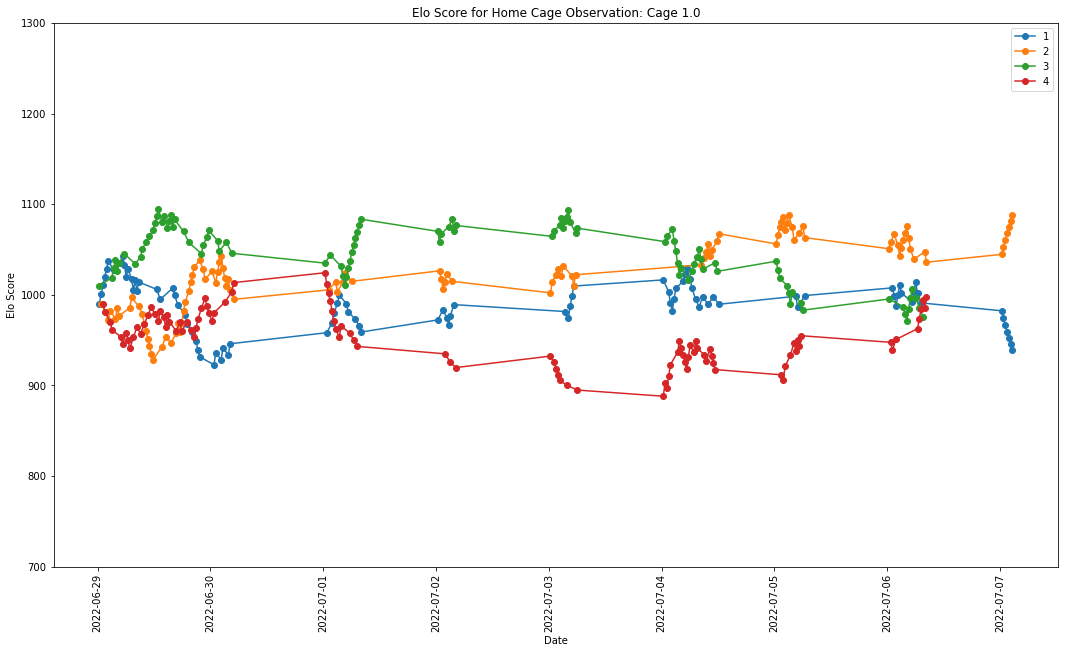

In [64]:
# Plotting for each cage
for cage in home_cage_elo_score_df["cage"].unique():
    fig, ax = plt.subplots()
    # Getting all the rows with the current cage number
    cage_df = home_cage_elo_score_df[home_cage_elo_score_df["cage"] == cage]
    
    # Plotting a line for each subject
    for subject in sorted(cage_df["subject_id"].unique()):
        # Getting all the rows with the current subject
        subject_df = cage_df[cage_df["subject_id"] == subject]
        # Making the dates into days after the first session by subtracting all the dates by the first date
        ax.plot(subject_df["date_time"], subject_df["updated_elo_score"], '-o', label=subject)
    
    
    
    # Setting the Y-Axis to only plot from 0 to 30 because we adjusted the latency to always be under 30
#     ax.set_ylim(0, 1)
    # Labeling the X/Y Axis and the title
    ax.set_xlabel("Date")
    ax.set_ylabel("Elo Score")
    ax.set_title("Elo Score for Home Cage Observation: Cage {}".format(cage))
    # To show the legend
    ax.legend()
    plt.xticks(rotation=90)
    plt.ylim(700, 1300) 
    file_name = "home_cage_elo_score_cage_{}_date_{}_{}.png".format(cage, earliest_date, latest_date)
#     plt.savefig(os.path.join("./proc/plots/home_cage", file_name))


In [129]:
home_cage_elo_score_df

,date,match_number,cage,subject_id,agent_id,original_elo_score,updated_elo_score,win_draw_loss,session_number,total_match_number,match_hour
0,2022-06-29,1,1.0,3,1,1000.0,1010.0,1,1.0,1,0.380952
1,2022-06-29,1,1.0,1,3,1000.0,990.0,0,1.0,1,0.380952
2,2022-06-29,2,1.0,1,2,990.0,1000.3,1,1.0,2,0.761905
3,2022-06-29,2,1.0,2,1,1000.0,989.7,0,1.0,2,0.761905
4,2022-06-29,3,1.0,1,4,1000.3,1010.3,1,1.0,3,1.142857
...,...,...,...,...,...,...,...,...,...,...,...
397,2022-07-07,5,1.0,1,2,958.9,951.9,0,15.0,199,1.904762
398,2022-07-07,6,1.0,2,1,1075.0,1081.6,1,15.0,200,2.285714
399,2022-07-07,6,1.0,1,2,951.9,945.3,0,15.0,200,2.285714
400,2022-07-07,7,1.0,2,1,1081.6,1087.9,1,15.0,201,2.666667


In [134]:
copy_home_cage_observations_df.dropna(axis=0, subset="date")

,observer,notes,length of observations,date,cage #,initiator,receiver,action,1,2,3,4
0,Isabel,"9:27-9:57am, C57 lots of grooming and rearing",30min,2022-06-29,1.0,3,1,fs,NaN,NaN,NaN,NaN
20,Meghan,"1:06-1:36PM, lots of grooming due to bleaching...",30min,2022-06-29,1.0,1,3,fs,NaN,NaN,NaN,NaN
46,Erika,"10:55 am - 11:25 am, C57",30 min,2022-06-29,1.0,2,4,as,NaN,NaN,NaN,NaN
62,Catalina,"C57, 2:30 pm - 3:00 pm",30 minutes,2022-06-30,1.0,2,4,fs,NaN,NaN,NaN,NaN
75,Naeliz,"C57, 10:58am-11:29am",30 min,2022-07-01,1.0,4,3,fs,NaN,NaN,NaN,NaN
96,Nancy,1157-1227pm observation after 30 min isolation...,30 min,2022-07-02,1.0,1,3,fs,NaN,NaN,NaN,NaN
107,Isabel,9:26am C57 observation without mouse 1,30min,2022-07-03,1.0,4,2,ag,NaN,NaN,NaN,NaN
113,Isabel,"more energetic when the alpha came back, but s...",15min,2022-07-03,1.0,3,2,fs,NaN,NaN,NaN,NaN
123,erika,"C57, removal of mouse 2, 10 min habituation (1...",30 min,2022-07-04,1.0,1,4,fs,NaN,NaN,NaN,NaN
144,erika,"C57, reintroduction of mouse 2 into cage, obse...",15 min,2022-07-04,1.0,2,3,fs,NaN,NaN,NaN,NaN


In [135]:
copy_home_cage_observations_df.dropna(axis=0, subset="date").index

Int64Index([0, 20, 46, 62, 75, 96, 107, 113, 123, 144, 155, 166, 172, 187,
            194],
           dtype='int64')

In [169]:
home_cage_elo_score_df.dropna(subset=["session_number_plotting"])

,date,match_number,cage,subject_id,agent_id,original_elo_score,updated_elo_score,win_draw_loss,session_number,session_number_plotting,total_match_number
0,2022-06-29,1,1.0,3,1,1000.0,1010.0,1,1.0,1.0,1
1,2022-06-29,1,1.0,1,3,1000.0,990.0,0,1.0,1.0,1
40,2022-06-29,21,1.0,1,3,1004.9,1016.1,1,2.0,2.0,21
41,2022-06-29,21,1.0,3,1,1045.2,1034.0,0,2.0,2.0,21
92,2022-06-29,47,1.0,2,4,958.7,969.0,1,3.0,3.0,47
93,2022-06-29,47,1.0,4,2,970.0,959.7,0,3.0,3.0,47
124,2022-06-30,1,1.0,2,4,1017.0,1025.9,1,4.0,4.0,63
125,2022-06-30,1,1.0,4,2,980.1,971.2,0,4.0,4.0,63
150,2022-07-01,1,1.0,4,3,1013.4,1024.3,1,5.0,5.0,76
151,2022-07-01,1,1.0,3,4,1045.8,1034.9,0,5.0,5.0,76


In [172]:
from labellines import labelLine, labelLines

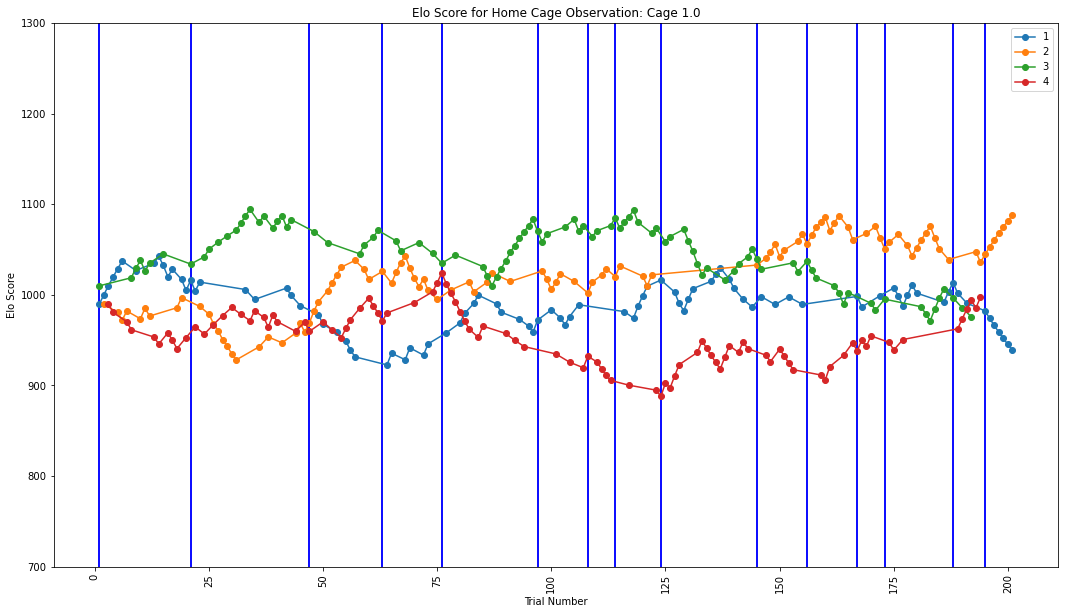

In [201]:
fig, ax = plt.subplots()



lines = []
for index, row in home_cage_elo_score_df.dropna(subset=["session_number_plotting"]).iterrows():
#     lines.append(plt.axvline(x = row["total_match_number"] - 0.5, color = 'b', label=row["session_number_plotting"]))
    plt.vlines(x=[row["total_match_number"]], ymin=700, ymax=1300, colors='b')

for subject in sorted(home_cage_elo_score_df["subject_id"].unique()):
    # Getting all the rows with the current subject
    subject_df = home_cage_elo_score_df[home_cage_elo_score_df["subject_id"] == subject]
    # Making the dates into days after the first session by subtracting all the dates by the first date
    plt.plot(subject_df["total_match_number"], subject_df["updated_elo_score"], '-o', label=subject)

# Setting the Y-Axis to only plot from 0 to 30 because we adjusted the latency to always be under 30
#     ax.set_ylim(0, 1)
# Labeling the X/Y Axis and the title
ax.set_xlabel("Trial Number")
ax.set_ylabel("Elo Score")
ax.set_title("Elo Score for Home Cage Observation: Cage {}".format(cage))
# To show the legend
ax.legend()
plt.xticks(rotation=90)
plt.ylim(700, 1300) 

file_name = "home_cage_elo_score_cage_{}_date_{}_{}.png".format(cage, earliest_date, latest_date)
#     plt.savefig(os.path.join("./proc/plots/home_cage", file_name))


In [114]:
home_cage_elo_score_df

,date,match_number,cage,subject_id,agent_id,original_elo_score,updated_elo_score,win_draw_loss,session_number
0,2022-06-29,1,1.0,3,1,1000.0,1010.0,1,1.0
1,2022-06-29,1,1.0,1,3,1000.0,990.0,0,1.0
2,2022-06-29,2,1.0,1,2,990.0,1000.3,1,1.0
3,2022-06-29,2,1.0,2,1,1000.0,989.7,0,1.0
4,2022-06-29,3,1.0,1,4,1000.3,1010.3,1,1.0
...,...,...,...,...,...,...,...,...,...
397,2022-07-07,5,1.0,1,2,958.9,951.9,0,15.0
398,2022-07-07,6,1.0,2,1,1075.0,1081.6,1,15.0
399,2022-07-07,6,1.0,1,2,951.9,945.3,0,15.0
400,2022-07-07,7,1.0,2,1,1081.6,1087.9,1,15.0


In [ ]:
all_cages = "_".join(sorted(home_cage_elo_score_df["cage"].unique()))

In [ ]:
all_cages

In [ ]:
home_cage_elo_score_df.to_csv("./proc/home_cage_elo_score_cage_{}_date_{}_{}.csv".format(all_cages, earliest_date, latest_date))
# elo_score_df.to_excel("./proc/id_to_date_elo_score.xlsx")